In [1]:
import numpy as np
from sklearn.decomposition import PCA
from torchvision import datasets, transforms, models
from latentmi import lmi, ksg
import seaborn as sns
import torch
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from collections import Counter


import torch.nn as nn
import torch.optim as optim

device='cuda'

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# define resnet model
class MobileNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super(MobileNetClassifier, self).__init__()
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)  # update final layer

    def forward(self, x):
        return self.mobilenet(x)
    
def train_model(model, dataloader, epochs=5, scale=0):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.numpy(), labels.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs, labels = torch.tensor(inputs).to(device).float(), torch.tensor(labels).to(device)  # back to tensor

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

# pca wrapper (top 16 pcs!)
def compute_pca(images, n_components=16):
    flat_images = images.reshape(images.shape[0], -1)
    scaler = StandardScaler()
    scaled_images = scaler.fit_transform(flat_images)  # normalize!
    pca = PCA(n_components=n_components)
    pcs = pca.fit_transform(scaled_images)
    return pcs

def resample_one_v_all(true_labels, target_label):
    target_indices = []
    other_indices = []
    for i, label in enumerate(true_labels):
        if target_label == label:
            target_indices.append(i)
        else:
            other_indices.append(i)

    other_indices = np.random.choice(other_indices, len(target_indices), replace=False)
    indices = np.concatenate([target_indices, other_indices])
    return indices.astype(int)


def estimate_mi(model, dataloader, scale=0):
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.numpy()  # to numpy
            if scale > 0:
                inputs = gaussian_noise(inputs, scale)  # downsample
            inputs = torch.tensor(inputs).to(device).float()  # back to tensor
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()

            true_labels.append(labels.numpy())
            predicted_labels.append(preds)

    true_labels = np.concatenate(true_labels)
    predicted_labels = np.concatenate(predicted_labels)

    MIs = []
    N_samples = []
    labels = []
    for label in np.unique(true_labels):
        N_samples.append(np.sum(true_labels == label))
        labels.append(label)
        indices = resample_one_v_all(true_labels, label)
        binarized_true_labels = true_labels[indices] == label
        binarized_pred_labels = predicted_labels[indices] == label
        MIs.append(ksg.midd(binarized_true_labels, binarized_pred_labels))

    MIs.append(ksg.midd(true_labels, predicted_labels))
    N_samples.append(len(true_labels))
    labels.append('all')

    return MIs, N_samples, labels

def gaussian_noise(images, scale):
    return np.random.normal(size=images.shape)*scale + images


In [3]:
transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # ensure RGB
    transforms.Resize((240, 240)),  # resize to a manageable resolution
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # normalize
])

# load dataset
Caltech101 = datasets.Caltech101(root='../data', download=True, transform=transform)

# get class labels
labels = Caltech101.y  # class indices for the dataset

# count occurrences of each class
class_counts = Counter(labels)

# find top n largest classes
top_n = 5
top_n_classes = [cls for cls, _ in class_counts.most_common(top_n)]

# subset the dataset to include only samples from these top classes
indices = [i for i, label in enumerate(labels) if label in top_n_classes]
subset = torch.utils.data.Subset(Caltech101, indices)

# split the subset into train and validation sets
N = len(subset)
print(f"{N} total samples")
train_set, val_set = torch.utils.data.random_split(subset, [N//2, N - N//2])

# create data loaders
data_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=128, shuffle=False)

Files already downloaded and verified
2707 total samples


In [4]:
d = {
    "Scale" : [],
    "MI" : [],
    "Class label" : [],
    "N instances of label" : []
}

MIs = []
scales = np.logspace(-2, 2, 10)

# process each factor
for scale in scales:

    model = MobileNetClassifier(num_classes=101)
    model.to('cuda')
    train_model(model, data_loader, epochs=5, scale=scale)

    # estimate mutual info
    mi, n_inst, labels = estimate_mi(model, val_loader, scale=scale)
    d['MI'] += mi
    d['Scale'] += [scale] * len(mi)
    d['Class label'] += labels
    d["N instances of label"] += n_inst

/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/gokul/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5, Loss: 2.6187
Epoch 2/5, Loss: 0.4200
Epoch 3/5, Loss: 0.0684
Epoch 4/5, Loss: 0.0244
Epoch 5/5, Loss: 0.0164
Epoch 1/5, Loss: 2.8477
Epoch 2/5, Loss: 0.4266
Epoch 3/5, Loss: 0.0612
Epoch 4/5, Loss: 0.0306
Epoch 5/5, Loss: 0.0180
Epoch 1/5, Loss: 2.8477
Epoch 2/5, Loss: 0.4460
Epoch 3/5, Loss: 0.0630
Epoch 4/5, Loss: 0.0270
Epoch 5/5, Loss: 0.0157
Epoch 1/5, Loss: 2.6862
Epoch 2/5, Loss: 0.4868
Epoch 3/5, Loss: 0.0879
Epoch 4/5, Loss: 0.0337
Epoch 5/5, Loss: 0.0197
Epoch 1/5, Loss: 3.4759
Epoch 2/5, Loss: 0.8437
Epoch 3/5, Loss: 0.1619
Epoch 4/5, Loss: 0.0613
Epoch 5/5, Loss: 0.0378
Epoch 1/5, Loss: 3.5290
Epoch 2/5, Loss: 1.2841
Epoch 3/5, Loss: 0.5094
Epoch 4/5, Loss: 0.2612
Epoch 5/5, Loss: 0.1441
Epoch 1/5, Loss: 4.2102
Epoch 2/5, Loss: 2.3965
Epoch 3/5, Loss: 1.2206
Epoch 4/5, Loss: 0.7651
Epoch 5/5, Loss: 0.5673
Epoch 1/5, Loss: 4.1395
Epoch 2/5, Loss: 2.8094
Epoch 3/5, Loss: 1.8436
Epoch 4/5, Loss: 1.3722
Epoch 5/5, Loss: 1.1556
Epoch 1/5, Loss: 4.0947
Epoch 2/5, Loss:

In [5]:
import pandas as pd
import seaborn as sns

In [6]:
df = pd.DataFrame(data=d)
# df

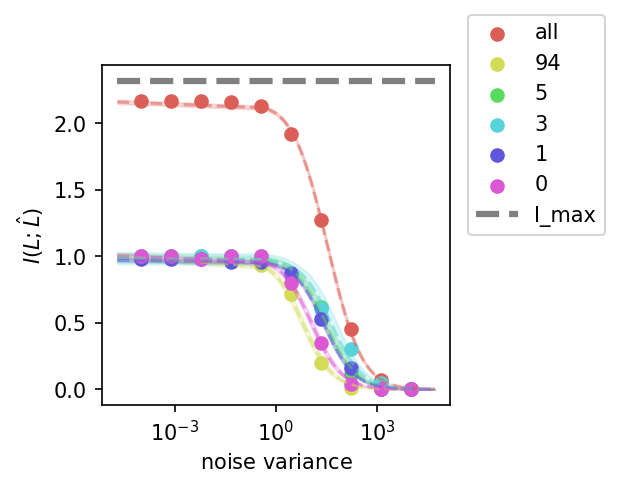

In [11]:
from lmfit import Model

def info_scaling(x, A, B):
    return 0.5 * np.log2(((1/x)*B+ 1)/(1+A*(1/x)))

fig = plt.figure(figsize=(3,3), dpi=150)


classes = df[df['N instances of label'] > 100]['Class label'].unique()
palette = sns.color_palette("hls", len(classes))

for i, x in enumerate(classes[::-1]):
    # prepare data
    x_data = df[df['Class label'] == x]['Scale']**2
    y_data = df[df['Class label'] == x]['MI']

    # create model and parameters
    model = Model(info_scaling)
    params = model.make_params(A=1e-2, B=1e-2)  # initial guesses
    params['A'].min = 0  # set bounds
    params['B'].min = 0

    # fit model
    result = model.fit(y_data, params, x=x_data)

    # generate fit line
    x_fit = np.linspace(x_data.min()/5, 5*x_data.max(), 10**5)
    y_fit = model.eval(params=result.params, x=x_fit)

    # calculate confidence bands
    y_upper = result.eval_uncertainty(params=result.params, 
                                      x=x_fit, sigma=2)
    y_lower = -y_upper

    # plot fit and data
    plt.plot(x_fit, y_fit, linestyle='--', color=palette[i], alpha=0.5)
    plt.fill_between(x_fit, y_fit + y_upper, y_fit + y_lower, color=palette[i], alpha=0.2)
    plt.scatter(x_data, y_data, color=palette[i], label=x)

I_max = np.log2(top_n)
plt.plot([np.min(x_fit), np.max(x_fit)], [I_max, I_max], linestyle='--', 
         color='grey', label='I_max', lw=3)


plt.xlabel(r'$\text{noise variance}$')
plt.ylabel(r'$I(L; \hat{L})$')
plt.xscale('log')
plt.legend(loc=(1.05, 0.5))

In [8]:
images, labels = [], []
for batch in data_loader:
    images.append(batch[0].numpy())
    labels.append(batch[1].numpy())

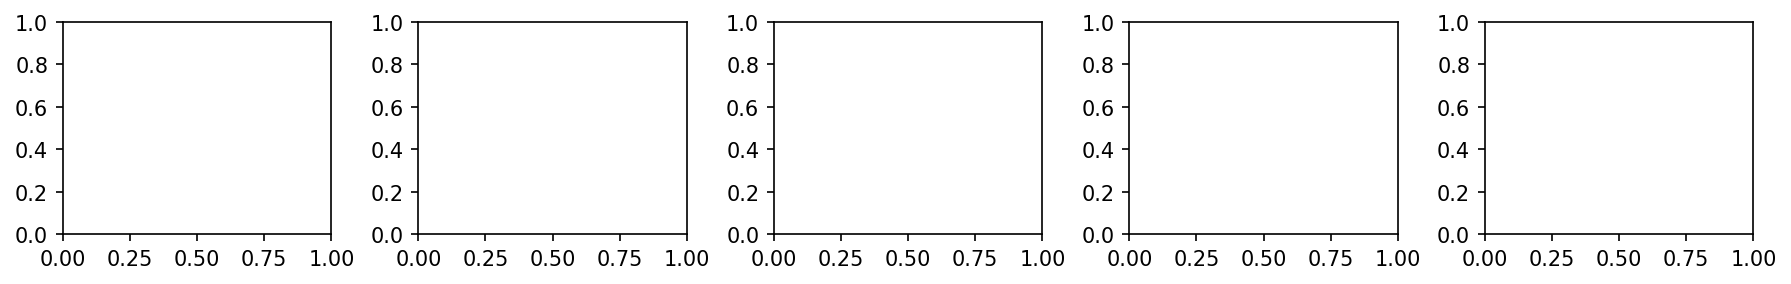

In [9]:
# label 90 is the good label


fig, axes = plt.subplots(1, len(scales[::2]), figsize=(12, 2), dpi=150)  # adjust figsize as needed
batch = 2
for idx, f in enumerate(scales[::2]):
    downsampled = gaussian_noise(images[batch], f)
    for i in range(len(images[0])):
        if labels[batch][i] == 90:
            axes[idx].axis('off')
            axes[idx].imshow(downsampled.transpose(0, 2, 3, 1)[i])
            axes[idx].set_title("factor %.3f" %f)
            break

plt.tight_layout()
plt.show()